# XGBoost Models | with feature selection and normalized data

**XGBRegressor**

- Approach 1: Binned by normalized depth interval
- Approach 2: Single XGB model trained and predicting over all data
- Inference: Shows promising results; should be improved using a neural network and KNN biome distribution mixing

Josie Donnelly

*Last updated 12.16.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time
import random
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor


## Preprocessing

In [2]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/results/'
file = 'float_sat_normalized_depth.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_orig = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
print(f'Shape: {df_orig.shape}')
df_orig.head()


Shape: (7623827, 31)


,float,latitude,longitude,cycleNumber,date,day_of_year_rad,PRES,PSAL,TEMP,BBP700,...,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,normalized_depth,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,3,35.539001,12.378333,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.012931,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,4,35.539001,12.378333,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.017241,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,6,35.539001,12.378667,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.025862,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,8,35.539001,12.379000,0.001789,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.034483,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,10,35.539001,12.379000,0.001790,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.043103,0.018,1.600373


In [3]:
df = df_orig[['float', 'cycleNumber', 'latitude', 'longitude', 'date', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'normalized_depth', 'CHLA']]
df = df.rename(columns={'cycleNumber': 'cycle'})
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

print(list(df.columns))


['float', 'cycle', 'latitude', 'longitude', 'date', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'normalized_depth', 'CHLA']


In [4]:
# the dtaframe includes only the cycles for which the euphotic depth is within the desired bounds
up_lim = 75
lo_lim = 300


In [5]:
# drop any example for which there is more than one missing satellite value
sat_feats = ['sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443']
df = df.dropna(axis=0, thresh=len(sat_feats)-1, subset=sat_feats).reset_index(drop=True)

print(f'Raw depth range represented: {min(df["PRES"])}m to {max(df["PRES"])}m')
print(f'Shape: {df.shape}')
df.head(5)


Raw depth range represented: 0m to 300m
Shape: (6536340, 14)


,float,cycle,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,3,0.012931,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,4,0.017241,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,6,0.025862,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,8,0.034483,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,10,0.043103,0.715552


In [6]:
print(f'Number of examples for which normalized_depth is missing: {df[df["normalized_depth"].isna()].shape[0]}')
# ensure normalized_depth and CHLA are not NA for any observations
df.isna().sum()


Number of examples for which normalized_depth is missing: 0


float                   0
cycle                   0
latitude                0
longitude               0
date                    0
day_of_year_rad         0
sat_chl                 0
sat_sst             36587
sat_pic             60364
sat_par              1468
sat_aph_443          4142
PRES                    0
normalized_depth        0
CHLA                    0
dtype: int64

In [7]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

## Display map of euphotic depth estimates

In [8]:
# function to plot a path of a float cycle on a map, colored by raw depth (PRES) by default
def plot_on_map(tmp_df, color_by='PRES', cmap='plasma_r', figsize=(10,4), title=None):
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    land.plot(color='lightgray', figsize=figsize)
    plt.scatter(tmp_df['longitude'], tmp_df['latitude'], c=tmp_df[color_by], cmap=cmap, s=1, alpha=0.5)
    cbar = plt.colorbar(label=color_by)
    cbar.ax.invert_yaxis()
    if title is None:
        plt.title(f'Cycle {tmp_df.loc[0,"cycleNumber"]} of Float {tmp_df.loc[0,"float"]}')
    else:
        plt.title(title)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    plt.show()
    

In [9]:
euphotic_depth_df = df[df['normalized_depth']==1.0].reset_index(drop=True)
euphotic_depth_df


,float,cycle,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610000,0.000306,27.891998,0.0357,232,1.0,0.014051
1,1902303,2,49.096,-14.617,2021-05-06 19:32:57,2.167505,0.553922,12.815000,0.000188,52.312000,0.0405,238,1.0,0.022796
2,1902303,3,48.914,-14.606,2021-05-07 20:05:38,2.184708,0.506032,12.480000,0.000192,16.085999,0.0395,210,1.0,0.019985
3,1902303,4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,142,1.0,0.024670
4,1902303,5,48.719,-14.795,2021-05-09 20:29:00,2.219113,0.509723,12.375000,0.000080,55.393997,0.0231,184,1.0,0.017174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46458,7901001,24,16.953,-23.772,2022-05-03 11:39:00,2.115898,0.151651,23.000000,0.000012,52.978001,0.0092,135,1.0,0.006893
46459,7901001,25,17.122,-23.670,2022-05-08 11:38:00,2.201910,0.153863,22.635000,0.000040,58.105999,0.0120,150,1.0,0.009463
46460,7901001,26,17.271,-23.511,2022-05-13 11:38:00,2.287922,0.144518,22.424999,0.000018,40.091999,0.0110,156,1.0,0.010828
46461,7901001,27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.660000,0.000018,58.424000,0.0122,152,1.0,0.010950


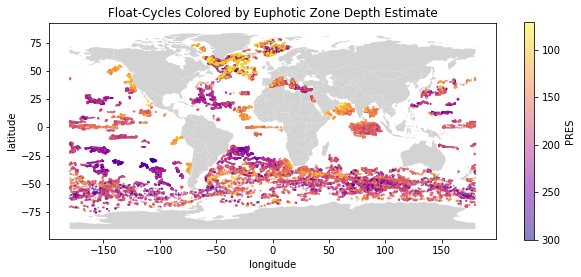

In [10]:
# display the observations colored by the depth of the euphotic floor
# results align with expectations from literature (Bock et al. 2022), such as the generally shallower euphotic depths in the Artic Ocean
plot_on_map(euphotic_depth_df, color_by='PRES', title='Float-Cycles Colored by Euphotic Zone Depth Estimate')


## Train-test split

In [11]:
# read in pre-determined train-test-split
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_sat_normalized_depth_train_test_split.csv'
train_test_split_df = pd.read_csv(path + file)
train_test_split_df = train_test_split_df[['float', 'cycleNumber', 'train']].rename(columns={'cycleNumber': 'cycle'})
train_test_split_df


,float,cycle,train
0,1902303,1,1
1,1902303,2,1
2,1902303,3,1
3,1902303,4,1
4,1902303,6,1
...,...,...,...
55851,2902755,278,0
55852,2902755,298,0
55853,2902755,266,0
55854,2902755,270,0


In [12]:
# notice that different floats may be mentioned in each dataframes
print(f'Number of floats in features df: {len(np.unique(df["float"]))}')
print(f'Number of floats in train-test-split df: {len(np.unique(train_test_split_df["float"]))}')

# merge the two dataframes
df_with_label = df.merge(right=train_test_split_df, how='inner', on=['float', 'cycle'], copy=False)
print(f'\nNumber of floats in merged df: {len(np.unique(df_with_label["float"]))}')

print(f'\nShape: {df_with_label.shape}')
df_with_label


Number of floats in features df: 556
Number of floats in train-test-split df: 565

Number of floats in merged df: 556

Shape: (6536340, 15)


,float,cycle,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,CHLA,train
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,0.012931,0.695875,1
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017241,0.695875,1
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,0.025862,0.696499,1
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,0.034483,0.716489,1
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,0.043103,0.715552,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536335,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,155,0.974843,0.014600,1
6536336,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,156,0.981132,0.013557,1
6536337,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,157,0.987421,0.012949,1
6536338,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,158,0.993711,0.012340,1


In [13]:
# ensure the rows of the dataframe are unique, including between train and test
df_with_label.shape[0] == df_with_label.drop(columns='train').drop_duplicates().shape[0]


True

In [14]:
# obtain train and test dataframes
train_df = df_with_label[df_with_label['train']==1].reset_index(drop=True).drop(columns='train')
test_df = df_with_label[df_with_label['train']==0].reset_index(drop=True).drop(columns='train')

print(f'Number of train observations: {train_df.shape[0]}')
print(f'Number of test observations: {test_df.shape[0]}')

# ensure that the train and test float cycles are distinct
train_float_cycles = np.unique([f'{f}_{c}' for f,c in zip(list(train_df['float']), list(train_df['cycle']))])
test_float_cycles = np.unique([f'{f}_{c}' for f,c in zip(list(test_df['float']), list(test_df['cycle']))])
print(f'\nNumber of unique train float-cycles: {len(np.unique(train_float_cycles))}')
print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


Number of train observations: 5261452
Number of test observations: 1274888

Number of unique train float-cycles: 37332
Number of unique test float-cycles: 9131
Number of float-cycle pairs in both train and test sets: 0


## Define functions

In [15]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(group_df, features, depth_bin):
    group_data_df = group_df[group_df['depth_bin'] == depth_bin]
    if 'normalized_depth' in group_data_df.columns:
        id_df = group_data_df[['depth_bin', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'CHLA']].rename(columns={'CHLA': 'true_CHLA'})
    else:
        id_df = group_data_df[['depth_bin', 'float', 'cycle', 'date', 'PRES', 'CHLA']].rename(columns={'CHLA': 'true_CHLA'})
    
    group_data_df = group_data_df[features]
    
    return group_data_df, id_df


In [16]:
def standardize(train_data_df, test_data_df, return_scaler=False):
    X_train = train_data_df.drop(columns='CHLA')
    y_train = train_data_df['CHLA']
    X_test = test_data_df.drop(columns='CHLA')
    y_test = test_data_df['CHLA']

    # perform (training) mean inputation for missing values by column
    for c in X_train.columns:
        c_train_mean = np.mean(X_train[c])
        X_train[c].fillna(value=c_train_mean, inplace=True)
        X_test[c].fillna(value=c_train_mean, inplace=True)
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
    
    if return_scaler:
        return X_train, X_test, y_train, y_test, ss
    return X_train, X_test, y_train, y_test
          

In [17]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds
    

In [18]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=False, plt_n_cols=5, single_plot=False):  
    if not single_plot:
        plt.subplot((len(bins)//plt_n_cols)+1,plt_n_cols,depth_idx+1)
    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    if normalized:
        plt.title(f'{int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}%', fontsize='x-large')
    else:
        plt.title(f'{bins[depth_idx]}m to {bins[depth_idx+1]}m', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend(loc='lower right')
    

## XGB regressor at varying depths

In [19]:
# define depth bins
interval = 0.1
bins = np.arange(0, 1+interval, interval)
bins
depth_bins = pd.cut(df['normalized_depth'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

try:
    train_df = train_df.drop(columns='depth_bin')
except:
    pass
train_df.insert(loc=list(train_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)

try:
    test_df = test_df.drop(columns='depth_bin')
except:
    pass
test_df.insert(loc=list(test_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)


In [20]:
# initialize dataframes to store results and predictions
results_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])
train_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])
test_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])

train_features = ['latitude', 'longitude', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'CHLA']
# train_features = ['latitude', 'longitude', 'day_of_year_rad', 'PRES', 'CHLA']     # to see how the model performs with only spatial and temporal features


DEPTH 0: 0% to 10% of the euphotic zone
	Num train samples: 510550  |  Num test samples: 133049
	Train MSE: 0.0069  |  Train r2: 0.9699
	Test MSE: 0.0926   |  Test r2: 0.5263

DEPTH 1: 10% to 20% of the euphotic zone
	Num train samples: 539637  |  Num test samples: 128305
	Train MSE: 0.0084  |  Train r2: 0.9625
	Test MSE: 0.1031   |  Test r2: 0.5182

DEPTH 2: 20% to 30% of the euphotic zone
	Num train samples: 535590  |  Num test samples: 127532
	Train MSE: 0.0075  |  Train r2: 0.9630
	Test MSE: 0.0774   |  Test r2: 0.5826

DEPTH 3: 30% to 40% of the euphotic zone
	Num train samples: 538270  |  Num test samples: 128335
	Train MSE: 0.0070  |  Train r2: 0.9656
	Test MSE: 0.0906   |  Test r2: 0.5633

DEPTH 4: 40% to 50% of the euphotic zone
	Num train samples: 537716  |  Num test samples: 128695
	Train MSE: 0.0075  |  Train r2: 0.9634
	Test MSE: 0.0867   |  Test r2: 0.5593

DEPTH 5: 50% to 60% of the euphotic zone
	Num train samples: 518457  |  Num test samples: 124984
	Train MSE: 0.0067 

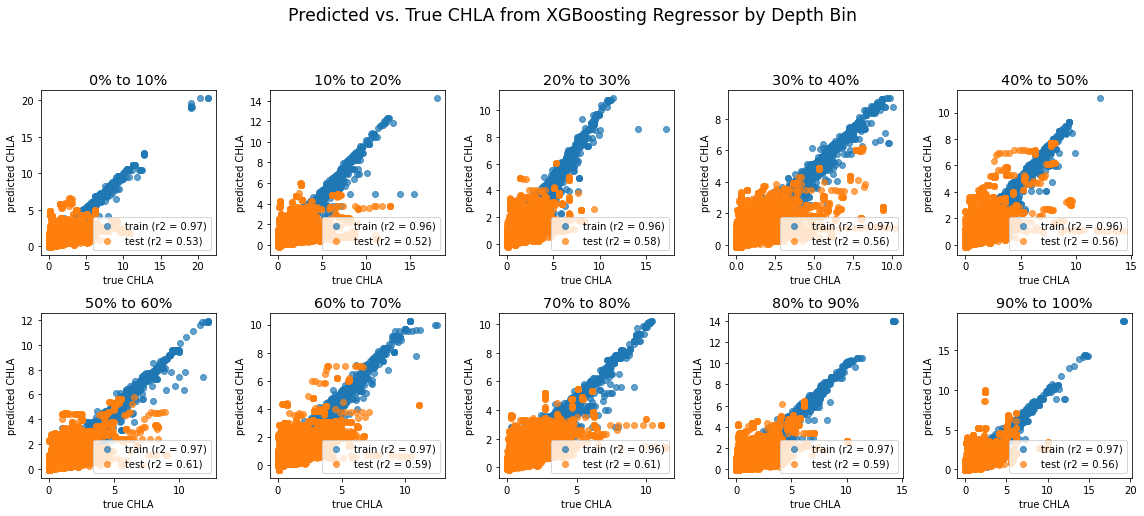

In [21]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(16,len(bins)-1))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin\n\n', fontsize='xx-large')
model_path = path + 'xgb_models/'

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}% of the euphotic zone')
    
    # obtain train and test data for this bin
    train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, features=train_features, depth_bin=depth_idx)
    test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, features=train_features, depth_bin=depth_idx)
    
    train_predictions_for_depth_df.insert(loc=list(train_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(train_predictions_for_depth_df.shape[0])])
    test_predictions_for_depth_df.insert(loc=list(test_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(test_predictions_for_depth_df.shape[0])])
    
    # standardize features based on training data
    X_train, X_test, y_train, y_test = standardize(train_data_df, test_data_df)

    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0: 
        print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
        print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
        print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
        print(f'Test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=True, plt_n_cols=5)
    
    # add scores and predictions to respective dataframes
    results_df.loc[results_df.shape[0]] = [depth_idx, (int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    train_predictions_for_depth_df['pred_CHLA'] = train_preds
    train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
    test_predictions_for_depth_df['pred_CHLA'] = test_preds
    test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])
    
    # save the model for this depth bin
    model_file = f'xgb_model_depth_bin_{depth_idx}'
    try:
        pickle.dump(xgbr, open(model_path + model_file, 'wb'))
    except:
        os.mkdir(model_path)
        pickle.dump(xgbr, open(model_path + model_file, 'wb'))
    
    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


## Display XGBoost regressor results

In [22]:
# display the dataframe of results
print(f'Average train r2: {np.mean(results_df["train_r2"])}')
print(f'Average test r2: {np.mean(results_df["test_r2"])}')
print(f'\nMaximum train r2: {np.max(results_df["train_r2"])}')
print(f'Maximum test r2: {np.max(results_df["test_r2"])}')
results_df


Average train r2: 0.9657727459247996
Average test r2: 0.5707706343062577

Maximum train r2: 0.9698815756104325
Maximum test r2: 0.6063345217909604


,depth_bin,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 10)",643599,0.006872,0.969882,0.092569,0.526253
1,1,"(10, 20)",667942,0.008412,0.962494,0.103114,0.518188
2,2,"(20, 30)",663122,0.007508,0.963030,0.077367,0.582619
3,3,"(30, 40)",666605,0.007009,0.965594,0.090608,0.563292
4,4,"(40, 50)",666411,0.007534,0.963413,0.086746,0.559336
5,5,"(50, 60)",643441,0.006748,0.968093,0.072820,0.606335
6,6,"(60, 70)",643680,0.007018,0.966914,0.076549,0.592230
7,7,"(70, 80)",643785,0.007860,0.961648,0.077786,0.605524
8,8,"(80, 90)",638146,0.006776,0.967919,0.080471,0.591676
9,9,"(90, 100)",659609,0.006706,0.968741,0.087552,0.562254


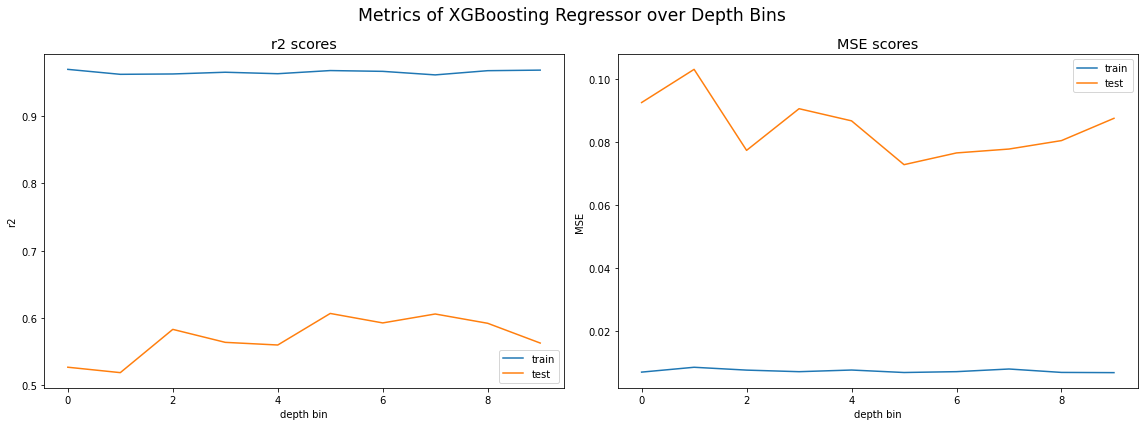

In [23]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


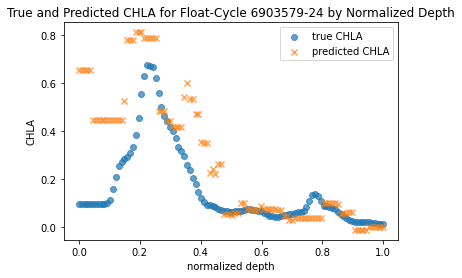

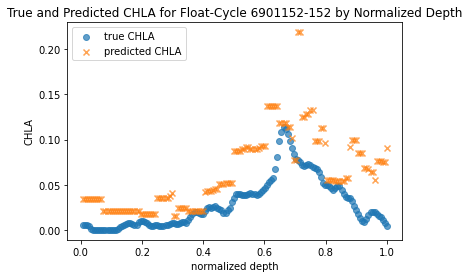

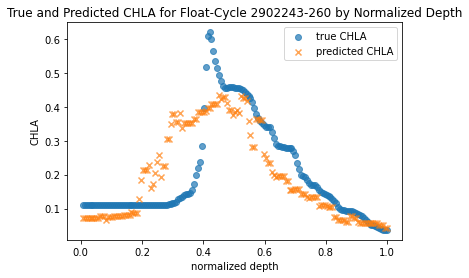

In [24]:
# display results for a few example float-cycles
for f_c in random.choices(test_float_cycles, k=3):
    f, c = f_c.split('_')
    f, c = int(f), int(c)
    tmp_df = test_predictions_df[(test_predictions_df['float'] == f) & (test_predictions_df['cycle'] == c)]
    plt.figure(figsize=(6,4))
    plt.scatter(tmp_df['normalized_depth'], tmp_df['true_CHLA'], alpha=0.7, marker='o', label='true CHLA')
    plt.scatter(tmp_df['normalized_depth'], tmp_df['pred_CHLA'], alpha=0.7, marker='x', label='predicted CHLA')
    plt.title(f'True and Predicted CHLA for Float-Cycle {f}-{c} by Normalized Depth')
    plt.xlabel('normalized depth')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
    

In [25]:
# save results and predictions
result_path = path + 'results/'
results_df.to_csv(result_path + 'results_xgb_feature_selection_normalized_ejd.csv', index=False)
train_predictions_df.to_csv(result_path + 'xgb_train_preds.csv', index=False)
test_predictions_df.to_csv(result_path + 'xgb_test_preds.csv', index=False)


## Repeat for one XGB model over all depths

In [26]:
# define depth bins
interval = 1
bins = np.arange(0, 1+interval, interval)
bins
depth_bins = pd.cut(df['normalized_depth'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

try:
    train_df = train_df.drop(columns='depth_bin')
except:
    pass
train_df.insert(loc=list(train_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)

try:
    test_df = test_df.drop(columns='depth_bin')
except:
    pass
test_df.insert(loc=list(test_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)


In [27]:
# initialize dataframes to store results and predictions
results_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])
train_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])
test_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float', 'cycle', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])

train_features = ['latitude', 'longitude', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'CHLA']
# train_features = ['latitude', 'longitude', 'day_of_year_rad', 'PRES', 'CHLA']


DEPTH 0: 0% to 100% of the euphotic zone
	Num train samples: 5261452  |  Num test samples: 1274888
	Train MSE: 0.0218  |  Train r2: 0.8969
	Test MSE: 0.0693   |  Test r2: 0.6477



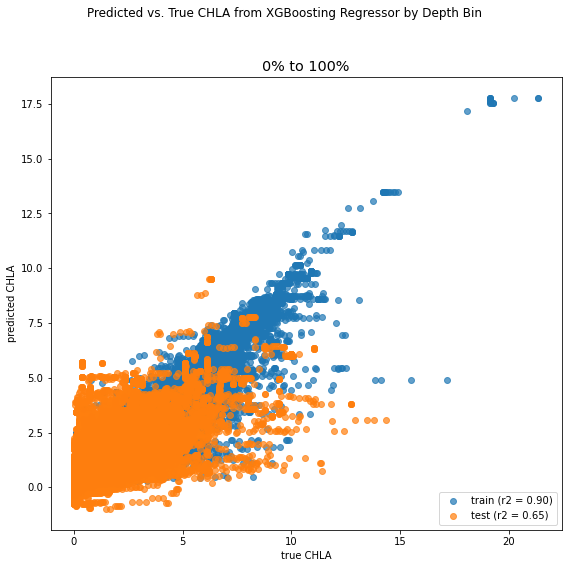

In [28]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(8,8))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin\n\n', fontsize='large')
model_path = path + 'xgb_single_model/'

depth_idx = 0

if verbose > 0:
    print(f'DEPTH {depth_idx}: {int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}% of the euphotic zone')

# obtain train and test data for this bin
train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, features=train_features, depth_bin=depth_idx)
test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, features=train_features, depth_bin=depth_idx)

train_predictions_for_depth_df.insert(loc=list(train_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(train_predictions_for_depth_df.shape[0])])
test_predictions_for_depth_df.insert(loc=list(test_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(test_predictions_for_depth_df.shape[0])])

# standardize features based on training data
X_train, X_test, y_train, y_test, ss = standardize(train_data_df, test_data_df, return_scaler=True)

if verbose > 0:
    print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
    print(f'Num test samples: {X_test.shape[0]}')

# train, predict, and get scores for XGBoosting regressor
xgbr = XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.7)     # grow_policy = 'depthwise' or 'lossguide'
train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)

if verbose > 0: 
    print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
    print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
    print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
    print(f'Test r2: {r2_score(y_test, test_preds):.4f}')

# plot predictions vs. true values
plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=True, single_plot=True)

# add scores and predictions to respective dataframes
results_df.loc[results_df.shape[0]] = [depth_idx, (int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
train_predictions_for_depth_df['pred_CHLA'] = train_preds
train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
test_predictions_for_depth_df['pred_CHLA'] = test_preds
test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])

# save the model for this depth bin
model_file = 'xgb_model'
try:
    pickle.dump(xgbr, open(model_path + model_file, 'wb'))
except:
    os.mkdir(model_path)
    pickle.dump(xgbr, open(model_path + model_file, 'wb'))

if verbose > 0:
    print()
        
plt.tight_layout()
plt.show()


In [29]:
# display the dataframe of results
results_df


,depth_bin,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 100)",6536340,0.021845,0.896907,0.069285,0.647708


In [30]:
# find R^2 values for various normalized depth bins
bins = np.arange(0,1.1,0.1)
for i in range(len(bins)-1):
    tmp_df = test_predictions_df[(test_predictions_df['normalized_depth'] >= bins[i]) & (test_predictions_df['normalized_depth'] < bins[i+1])]
    print(f'Test r2 ({int(bins[i]*100)}–{int(bins[i+1]*100)}%): {r2_score(tmp_df["true_CHLA"], tmp_df["pred_CHLA"]):.4f}')
    # uncomment to view corresponding scatter plots
#     plt.figure(figsize=(4,4))
#     plt.scatter(tmp_df['true_CHLA'], tmp_df['pred_CHLA'])
#     plt.show()
    

Test r2 (0–10%): 0.6663
Test r2 (10–20%): 0.6805
Test r2 (20–30%): 0.6570
Test r2 (30–40%): 0.6055
Test r2 (40–50%): 0.5558
Test r2 (50–60%): 0.4291
Test r2 (60–70%): 0.1867
Test r2 (70–80%): -0.1965
Test r2 (80–90%): -1.7142
Test r2 (90–100%): -11.9078


In [31]:
# repeat for normalized depth bins
bins = np.arange(0,max(test_df['PRES'])+25,25)
for i in range(len(bins)-1):
    tmp_df = test_predictions_df[(test_predictions_df['PRES'] >= bins[i]) & (test_predictions_df['PRES'] < bins[i+1])]
    print(f'Test r2 ({bins[i]}–{bins[i+1]}m): {r2_score(tmp_df["true_CHLA"], tmp_df["pred_CHLA"]):.4f}')
    # uncomment to view corresponding scatter plots
#     plt.figure(figsize=(4,4))
#     plt.scatter(tmp_df['true_CHLA'], tmp_df['pred_CHLA'])
#     plt.show()
    

Test r2 (0–25m): 0.6711
Test r2 (25–50m): 0.6123
Test r2 (50–75m): 0.5647
Test r2 (75–100m): 0.4935
Test r2 (100–125m): 0.3056
Test r2 (125–150m): 0.2160
Test r2 (150–175m): 0.1305
Test r2 (175–200m): -0.4551
Test r2 (200–225m): -1.4474
Test r2 (225–250m): -1.7908
Test r2 (250–275m): -8.5049
Test r2 (275–300m): -51.7420


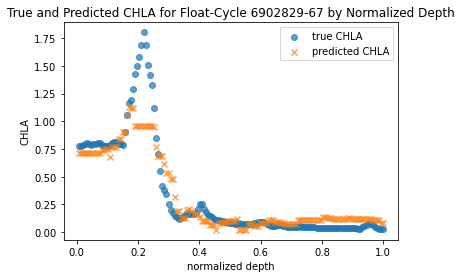

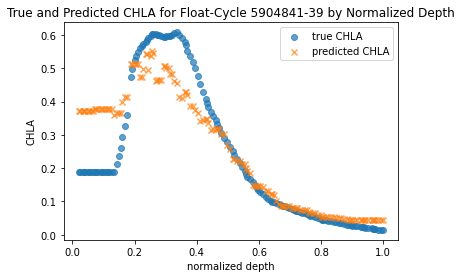

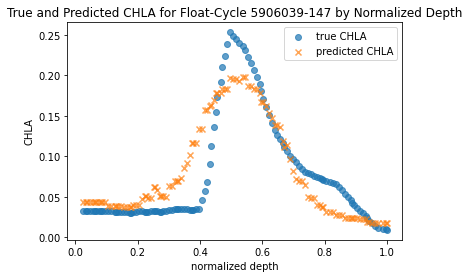

In [32]:
# display results for a few example float-cycles
for f_c in random.choices(test_float_cycles, k=3):
    f, c = f_c.split('_')
    f, c = int(f), int(c)
    tmp_df = test_predictions_df[(test_predictions_df['float'] == f) & (test_predictions_df['cycle'] == c)]
    plt.figure(figsize=(6,4))
    plt.scatter(tmp_df['normalized_depth'], tmp_df['true_CHLA'], alpha=0.7, marker='o', label='true CHLA')
    plt.scatter(tmp_df['normalized_depth'], tmp_df['pred_CHLA'], alpha=0.7, marker='x', label='predicted CHLA')
    plt.title(f'True and Predicted CHLA for Float-Cycle {f}-{c} by Normalized Depth')
    plt.xlabel('normalized depth')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
    

In [33]:
# save results and predictions
results_df.to_csv(result_path + 'results_xgb_single_model_feature_selection_normalized_ejd.csv', index=False)
train_predictions_df.to_csv(result_path + 'xgb_single_model_train_preds.csv', index=False)
test_predictions_df.to_csv(result_path + 'xgb_single_model_test_preds.csv', index=False)


## Inference: the process if given only unseen satellite data

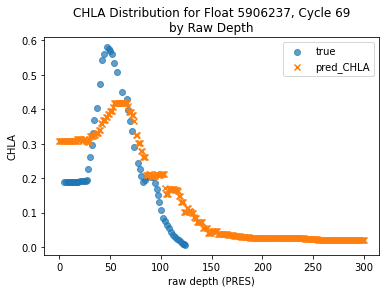

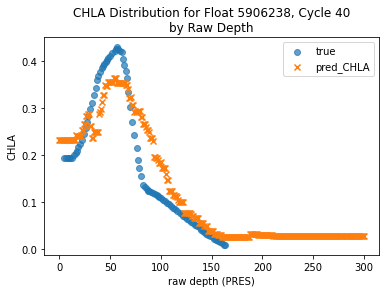

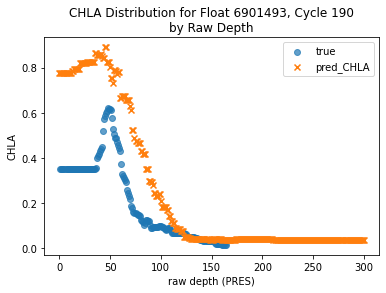

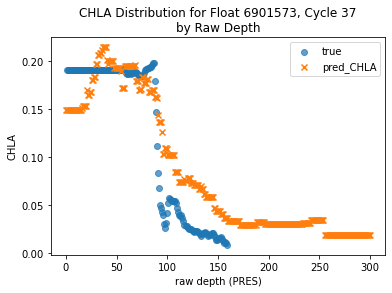

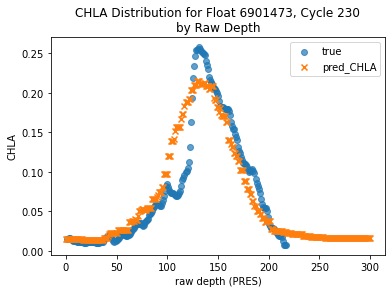

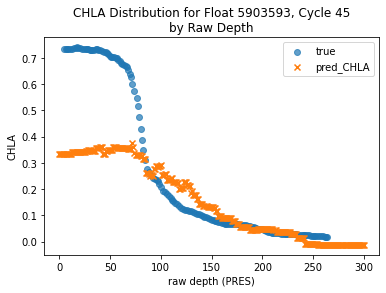

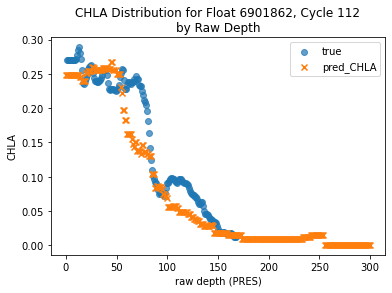

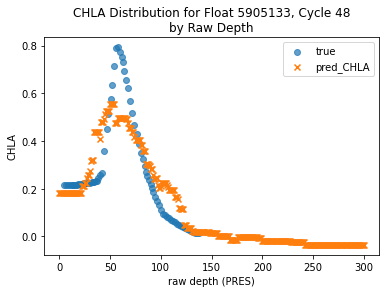

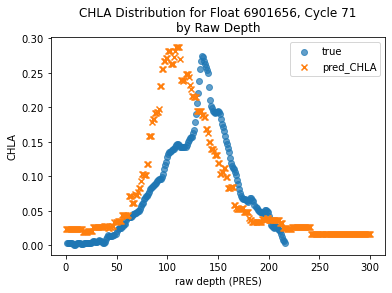

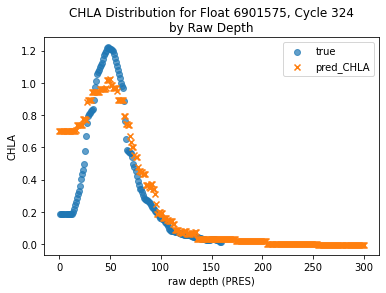

In [34]:
# note: in inference, all examples infer to raw depth 300 m for consistency
# this will not be necessary after label standardization is complete; see preliminary_models/xgb_standardized_inputs_11_ejd.ipynb

num = 10
for i in range(num):
    # choose a random float-cycle from the test data
    f = random.choice(test_df['float'])
    float_df = test_df[test_df['float']==f]
    c = random.choice(np.unique(float_df['cycle']))
    cycle_df = float_df[float_df['cycle']==c]
    
    # obtain just the features (without raw depth), as if using unseen satellite data
    feats_df = cycle_df[train_features[:-2]].drop_duplicates()
    
    # perform a cross join to get predictions for every 20m of raw depth from the surface to 300m
    depths_df = pd.DataFrame({'raw_depth': np.arange(0,301,1)})
    feats_df = feats_df.merge(right=depths_df, how='cross')
    
    # standardize features
    std_feats_df = feats_df.copy()
    std_feats_df[std_feats_df.columns] = ss.transform(feats_df[feats_df.columns])
    
    # obtain predictions
    preds = xgbr.predict(std_feats_df)

    # plot true and predicted CHLA values
    plt.figure(figsize=(6,4))
    plt.scatter(cycle_df['PRES'], cycle_df['CHLA'], marker='o', alpha=0.7, label='true')
    plt.scatter(feats_df['raw_depth'], preds, marker='x', label='pred_CHLA')
    plt.title(f'CHLA Distribution for Float {f}, Cycle {c}\nby Raw Depth')
    plt.xlabel('raw depth (PRES)')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
